# IMDb Rating Predicition
In diesem Projekt soll herausgefunden werden, ob anhand von verschiedenen Daten von einem Film die durchschnittliche Bewertung von einem Film mit Hilfe von Machine Learning vorhersagen kann.
Dazu wird die IMDB Datenbank verwendet, die in Teilen frei zugänglich ist. Dabei waren die Hauptherausforderungen die Auswahl der Daten und die Logik hinter diesem Vorhaben.

## Die IMDb Datenbank
Ein ausgewählter Teil der IMDb Datenbank ist im Internet frei zugänglich und kann beispielsweise auf Kaggle gefunden werden.
Es handelt sich dabei um eine relationale Datenbank, welche mehrere Tabellen enthält.


In [1]:
%load_ext autoreload
%reload_ext autoreload
%matplotlib inline
import database_connector
import main
db = database_connector.DataBase()
tables = db.show_tables()

for table in tables:
    field_info_text = db.get_table_field_info(table)

    print(f"Spalten der Tabelle {table}:")
    print("\n".join(field_info_text))
    print("\n")


Spalten der Tabelle most_rated_movies:
primaryTitle: VAR_STRING 
numVotes: LONG NUMERIC


Spalten der Tabelle person:
nconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
primaryName: VAR_STRING 
birthYear: LONG NUMERIC
deathYear: LONG NUMERIC
primaryProfession: VAR_STRING 
knownForTitles: VAR_STRING 
averageRating: DOUBLE NUMERIC


Spalten der Tabelle titleakas:
titleId: STRING NOT_NULL | NO_DEFAULT
ordering: LONG NOT_NULL | NUMERIC
title: VAR_STRING 
region: STRING 
language: STRING 
types: VAR_STRING 
attributes: VAR_STRING 
isOriginalTitle: LONG NUMERIC


Spalten der Tabelle titlebasic:
tconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
titleType: VAR_STRING 
primaryTitle: VAR_STRING 
originalTitle: VAR_STRING 
isAdult: LONG NUMERIC
startYear: LONG NUMERIC
endYear: LONG NUMERIC
runtimeMinutes: LONG NUMERIC
genres: VAR_STRING 


Spalten der Tabelle titleprincipals:
tconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
ordering: LONG NUMERIC
nconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFA

Dabei sind die Daten nicht komplett sauber, viele Einträge sind fehlerhaft oder unvollständig.
Deshalb ist es besonders wichtig, die Daten zu filtern und nur diese zu nehmen, die relevant sind.

In [2]:
db.sql("SELECT COUNT(*) FROM titlebasic")[0]

(5701079,)

Die Tabelle Titlebasic beinhaltet alle Titel und ist wie zu sehen ist 5 Millionen einträge groß

In [3]:
db.sql("SELECT COUNT(*) FROM titlebasic WHERE titleType = 'Movie'")[0]

(509332,)

Davon sind eine halbe Millionen Filme

In [4]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie'")[0]

(237738,)

Davon haben etwa 200k überhaupt eine Bewertung


In [5]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie' AND titleratings.numVotes > 50000")[0]


(3023,)

Davon haben nur 3000 über 50000 Bewertungen, ein Wert bei welchem wir festgestellt haben, dass die Bewertungen eine ausreichende Aussagekraft besitzen.
Das sind die Filme, die als "Valid_Movies" angesehen werden und in dieser view dargestellt werden.

In [6]:
db.sql("SELECT primaryTitle, startYear, runtimeMinutes, genres FROM imdb.valid_movies order by startYear DESC limit 8")

[('The Pancake Ghost', 2021, 0, 'Musical'),
 ('Mayday', 2020, 0, 'Drama'),
 ('I Am Mother', 2019, 113, 'Drama,Horror,Sci-Fi'),
 ('The Highwaymen', 2019, 132, 'Biography,Crime,Drama'),
 ('Captain Marvel', 2019, 123, 'Action,Adventure,Sci-Fi'),
 ('Hellboy', 2019, 120, 'Action,Adventure,Fantasy'),
 ('Midsommar', 2019, 147, 'Drama,Horror,Mystery'),
 ('It Chapter Two', 2019, 169, 'Drama,Fantasy,Horror')]

Dabei sieht die Liste der best bewertetsten Filme der Ansicht auf der IMDb Website ähnlich, es scheinen also ähnliche Filter angewendet worden zu sein.

In [7]:
db.get_top_rated_movies()

[('The Shawshank Redemption', 1994, 9.3, 2159745),
 ('The Godfather', 1972, 9.2, 1482225),
 ('The Godfather: Part II', 1974, 9.0, 1032110),
 ('The Dark Knight', 2008, 9.0, 2134602),
 ('The Mountain II', 2016, 9.0, 101817),
 ('12 Angry Men', 1957, 8.9, 617607),
 ("Schindler's List", 1993, 8.9, 1120297),
 ('Pulp Fiction', 1994, 8.9, 1695159),
 ('The Lord of the Rings: The Return of the King', 2003, 8.9, 1533632),
 ('The Good, the Bad and the Ugly', 1966, 8.8, 640941),
 ('Forrest Gump', 1994, 8.8, 1662609),
 ('The Lord of the Rings: The Fellowship of the Ring', 2001, 8.8, 1548920),
 ('Fight Club', 1999, 8.8, 1725444),
 ('Inception', 2010, 8.8, 1892958),
 ('Joker', 2019, 8.8, 466912),
 ("One Flew Over the Cuckoo's Nest", 1975, 8.7, 852798),
 ('Star Wars: Episode V - The Empire Strikes Back', 1980, 8.7, 1078754),
 ('Goodfellas', 1990, 8.7, 933687),
 ('The Matrix', 1999, 8.7, 1554345),
 ('The Lord of the Rings: The Two Towers', 2002, 8.7, 1387208),
 ("It's a Wonderful Life", 1946, 8.6, 36675

## Auswahl der Daten
Da wir nun die Auswahl der Datensätze getroffen haben, geht es nun darum, Attribute auszuwählen, die für das neurale Netzwerk genutzt werden können

In [8]:
movies = main.loadDataBase()
inception = movies[2213]
print(f"ID\t\t{inception.id}\nTitel\t\t{inception.title}\nJahr\t\t{inception.startYear}\nLaufzeit\t{inception.runtimeMinutes}\nGenres\t\t{inception.genres}\nAverage Rating\t{inception.averageRating}\nNumber of Votes\t{inception.numVotes}")

Loading Database...
100.0% 	 Time elapsed: 0:00:01.629s
Database loaded.
ID		tt1375666
Titel		Inception
Jahr		2010
Laufzeit	148
Genres		['Action', 'Adventure', 'Sci-Fi']
Average Rating	8.8
Number of Votes	1892958


Diese Daten bestimmen das Movie Objekt. Die meisten dieser Daten werden auch dem neuralen Netzwerk mitgegeben, einige dienen nur zur Information. Einem Movie gehören bis zu 10 "Mitarbeitern" an. Dazu zählen Schauspieler, Regisseure, Producer, Komponisten, etc.

In [9]:
crew = inception.actors
print("%-28s %-4s %20s" % ("Name", "Nummer", "Rolle  "))
for person in crew:
    print ("%-28s %-4s %20s" % (person.getName(),person.ordering,person.category))

Name                         Nummer              Rolle  
Leonardo DiCaprio            1                   actor
Joseph Gordon-Levitt         2                   actor
Ellen Page                   3                 actress
Ken Watanabe                 4                   actor
Christopher Nolan            5                director
Emma Thomas                  6                producer
Hans Zimmer                  7                composer
Wally Pfister                8         cinematographer
Lee Smith                    9                  editor
Guy Hendrix Dyas             10    production_designer


Name ist dabei eigentlich "ID", hier aber zur besseren Lesbarkeit als Name dargestellt. <br>
Von den kombinierten Tabellen "person" und "titleprincipals" sind dies die daten, die sinnvoll sind. <br>
Nun ist die Frage, welche der Attribute von Movie und Actor für die Ermittlung des Scores wichtig sind. <br>

Da stellt sich die Frage, welcher dieser Attribute den Score beeinflussen.<br>
Zunächst wurden dabei die Attribute `startYear`,`runtime`, `genre` und `actor` geeinigt, wobei bei actor die attribute `nconst` (id), `ordering` (nummer) und `category` (Rolle) beinhaltet. Diese Attribute unterscheiden einen Film, können jedoch auch gleichzeitig in mehreren Filmen gleich sein, was eine voraussetzung für das lernen ist. Je mehr gleiche Attribute, desto einfacher kann das neurale Netzwerk lernen.
Attribute wie die ID oder der Titel eines Films machen keinen Sinn, da sich diese niemals im Datensatz wiederholen. Es könnte lediglich auf einige Schlagwörter eingegangen werden oder die länge des Filmtitels berücksichtigt werden.

## Learning Tests

Die ersten Tests wurden mit dem MLPRegressor durchgeführt, welcher über Regression versucht einen Zusammenhang herzustellen. Der Test Score war dabei allerdings bei einem Prozent, weshalb nach einer anderen Lösung gesucht wurde.
Deswegen wurde mit den oben genannten Attributen ein MLPClassifier von Scikit learn trainiert. Dieser versucht anhand von verschiedenen Attributen den Film in eine Klasse einzuordnen. Die Klassen sind dabei verschiedene Ratings. Hier lagen anfangs die Test Scores bei etwa 50%.
Jedoch wurde bei manuellen Tests klar, dass der Classifier sehr konservative Ratings vorhersagt, die in der Regel zwischen fünf und sieben Sternen lagen. Dadurch könnte der Test Score allein durch konservatives raten so hoch sein.

Hier stellte sich die Frage, warum der Classifier so "vorsichtig" rät. Die Vermutung bestand, dass der Classifier <br>
* nicht genügend Daten pro Film hat,
* mit den Daten des Films nichts anfangen kann,
* oder zwischen den Daten und dem Rating des Films kein Zusammenhang besteht.

Um der ersten Vermutung nachzugehen wurde außerdem die Anzahl der Ratings als Attribut mitgegeben. Damit erhöhte sich der Test Score allerdings nur geringfügig.

Um der zweiten Vermutung nachzugehen, könnte anstatt eines Schauspielers die durchschnittliche Bewertung aller Filme mitgegeben werden, an denen dieser partizipiert hat.
Hiermit steigerte sich der Score auf etwa 75%. Auch wurde mit einem decision Tree anstatt einem neuralen Netzwerk getestet, hier gab es ähnliche Scores, wobei hier teils geringere Ladezeiten aufgetreten sind.
Beim lernen kann deshalb entschieden werden, ob ein neurales Netzwerk genutzt werden soll oder ob der decision Tree genutzt werden soll.

## Der Predictor
Zunächst werden alle Filme aus der Datenbank geladen.

In [10]:
import database_connector
import ratingPredictor

allMovies = main.loadDataBase()

Loading Database...
100.0% 	 Time elapsed: 0:00:01.575s
Database loaded.


Nun wird der Rating Predictor, also unser Decision Tree/Neurales Netwerk erzeugt und trainiert sich an den Daten allMovies.

In [11]:
rater = ratingPredictor.ratingPredictor(allMovies)
#rater.printallmovies()
clf = rater.learn(False) #Mit neural Network = True wird ein neurales Netzwerk genutzt anstatt der decision tree

Converting data...
100.0% 	 Time elapsed: 0:00:09.439s
Data converted.
Training started...
Training done.
Test score is:
0.7599206349206349


Nun kann dieser RatingPredictor auch Bewertungen von Filmen vorhersagen. Dazu können wir uns anschauen, welche Möglichkeiten wir haben, einen Film zu erstellen.

In [12]:
rater.getAllRoles()

['actor',
 'actress',
 'director',
 'writer',
 'composer',
 'producer',
 'cinematographer',
 'editor',
 'self',
 'production_designer',
 'archive_footage']

Dies sind alle Rollen, die ein Schauspieler/Crew haben kann. Diese müssen auch genau so geschrieben werden, damit sie erkannt werden.

In [13]:
rater.getAllGenres()

['Fantasy',
 'Horror',
 'Mystery',
 'Comedy',
 'Drama',
 'Family',
 'Adventure',
 'Sci-Fi',
 'Action',
 'War',
 'Romance',
 'Crime',
 'Thriller',
 'Musical',
 'Animation',
 'History',
 'Film-Noir',
 'Western',
 'Music',
 'Biography',
 'Sport',
 'Documentary',
 'News']

Dies sind alle Genres, die ein Film haben kann. Ein Film kann bis zu drei Genres haben, braucht jedoch nur eins.

Ein Film kann nach dem Schema (Titel(String), Veröffentlichungsjahr(int), Laufzeit(int), Genre1(String), Genre2(String), Genre3(String), Anzahl der Bewertungen(int)) erzeugt werden. Anschließend können schauspieler mit der Funktion `addCrewByName` hinzugefügt werden, mit dem Schema (Name(String), Rolle(String))

In [14]:
newMovie = main.createMovie("Mein neuer Film",2000,120,"Action","Crime","War",100000)
newMovie.addCrewByName("Johnny Depp", "actor")
newMovie.addCrewByName("Christian Bale", "actor")
newMovie.addCrewByName("Michael Bay","director")
newMovie.addCrewByName("John Williams", "composer")
newMovie.getAsString()

"Mein neuer Film (2000) Länge: 120min Genres: ['Action', 'Crime', 'War'] Bewertung: 0 mit 100000 Bewertungen. Mit ['Johnny Depp', 'Christian Bale', 'Michael Bay', 'John Williams']"

Nun kann der RatingPredictor das Rating vorhersagen

In [15]:
rater.predictMovie(newMovie)

Converting data...
100.0% 	 Time elapsed: 0:00:00.002s
Data converted.


array([8])

<BarContainer object of 9 artists>

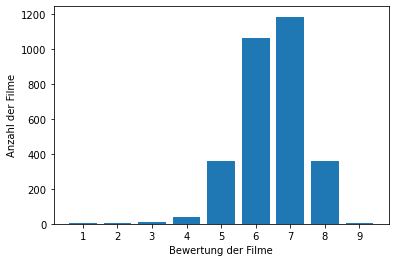

In [16]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.ylabel('Anzahl der Filme')
plt.xlabel('Bewertung der Filme')
x = [1,2,3,4,5,6,7,8,9]
plt.xticks(x)
x, y = rater.plot_ratings()
plt.bar(x,y)

Text(0.5, 1.0, 'Confusion Matrix')

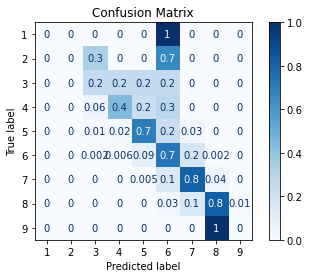

In [33]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
x_startYear = rater.split_xtest(1)
#disp = plot_roc_curve(clf, rater.x_test, rater.y_test)
disp = plot_confusion_matrix(clf, rater.x_test, rater.y_test,
                                 display_labels=[1,2,3,4,5,6,7,8,9],
                                 cmap='Blues',
                                 normalize='true',
                                values_format='.0g')
disp.ax_.set_title('Confusion Matrix')

In [35]:
from sklearn.metrics import classification_report
y_pred, y_true = rater.predictAllTestValues()
print(classification_report(y_true, y_pred, zero_division = 0))

C:\Users\Anton\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Fazit: Filmnamelänge: Kurz eher schlechter, länger eher besser
       Jahr: Kaum auswirkungen, außer in extrembereichen
       Fimlänge: Kaum auswirkungen
       Anzahl der Bewertungen: Je mehr, desto besser
       
        